In [15]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.callbacks import ReduceLROnPlateau

sns.set()


image = tf.keras.preprocessing.image
ImageDataGenerator = image.ImageDataGenerator

In [16]:
# Getting names of the classes we have
data1_directory = pathlib.Path('data/raw/Fruits Classification/test')
class_names = [item.name for item in data1_directory.glob('*')][:5]
print(class_names)

['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [17]:
# Getting names of the classes we have
data2_directory = pathlib.Path('data/raw/Fruits Classification/train')
class_names = sorted([item.name for item in data1_directory.glob('*')][:5])
print(class_names)

['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [18]:
test_dir = pathlib.Path("data/raw/Fruits Classification/test")
modelpath = "out/models/model.h5"

In [19]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data1_directory, 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data1_directory, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 80 images belonging to 5 classes.
Found 20 images belonging to 5 classes.


In [20]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data2_directory, 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data2_directory, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 7760 images belonging to 5 classes.
Found 1940 images belonging to 5 classes.


In [21]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [22]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """
    
    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 10))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()       
    plt.show()

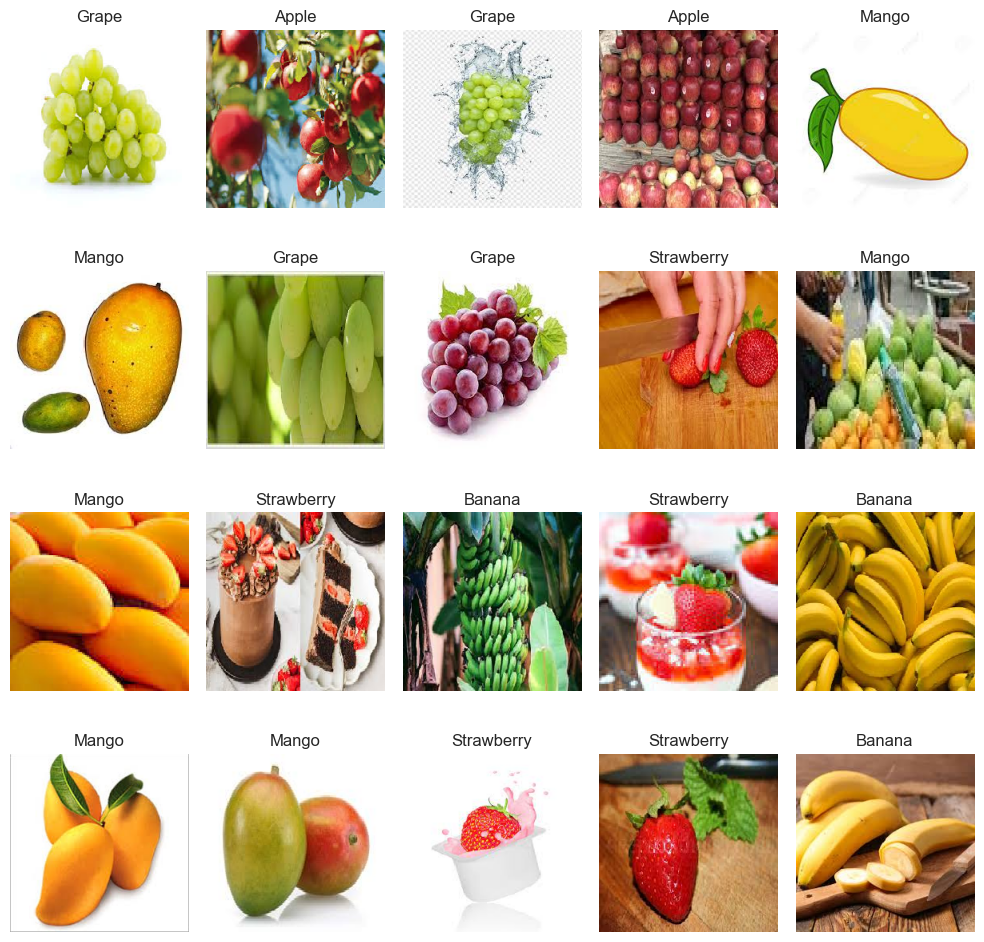

In [23]:
plot_random_images()

In [24]:
model = tf.keras.Sequential([
            tf.keras.Input(shape = images[0].shape),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(5, activation = 'softmax'),
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 200704)           

In [26]:
callbacks = [
    ReduceLROnPlateau(
        monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001
    )
]

In [27]:
classifier = model.fit(
    train_data, batch_size=32, epochs=5, validation_data=val_data, callbacks=callbacks
)

Epoch 1/5
243/243 [==============================] - 231s 948ms/step - loss: 1.4347 - accuracy: 0.4546 - val_loss: 1.2384 - val_accuracy: 0.4747 - lr: 0.0010
Epoch 2/5
243/243 [==============================] - 227s 932ms/step - loss: 0.9558 - accuracy: 0.6192 - val_loss: 1.1357 - val_accuracy: 0.5340 - lr: 0.0010
Epoch 3/5
243/243 [==============================] - 284s 1s/step - loss: 0.6010 - accuracy: 0.7762 - val_loss: 1.3337 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 4/5
243/243 [==============================] - 264s 1s/step - loss: 0.3040 - accuracy: 0.8986 - val_loss: 1.6234 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 5/5
243/243 [==============================] - 233s 957ms/step - loss: 0.1501 - accuracy: 0.9539 - val_loss: 2.0301 - val_accuracy: 0.5134 - lr: 0.0010


In [28]:
model.evaluate(val_data)

61/61 [==============================] - 12s 195ms/step - loss: 2.0301 - accuracy: 0.5134


[2.0300562381744385, 0.5134020447731018]

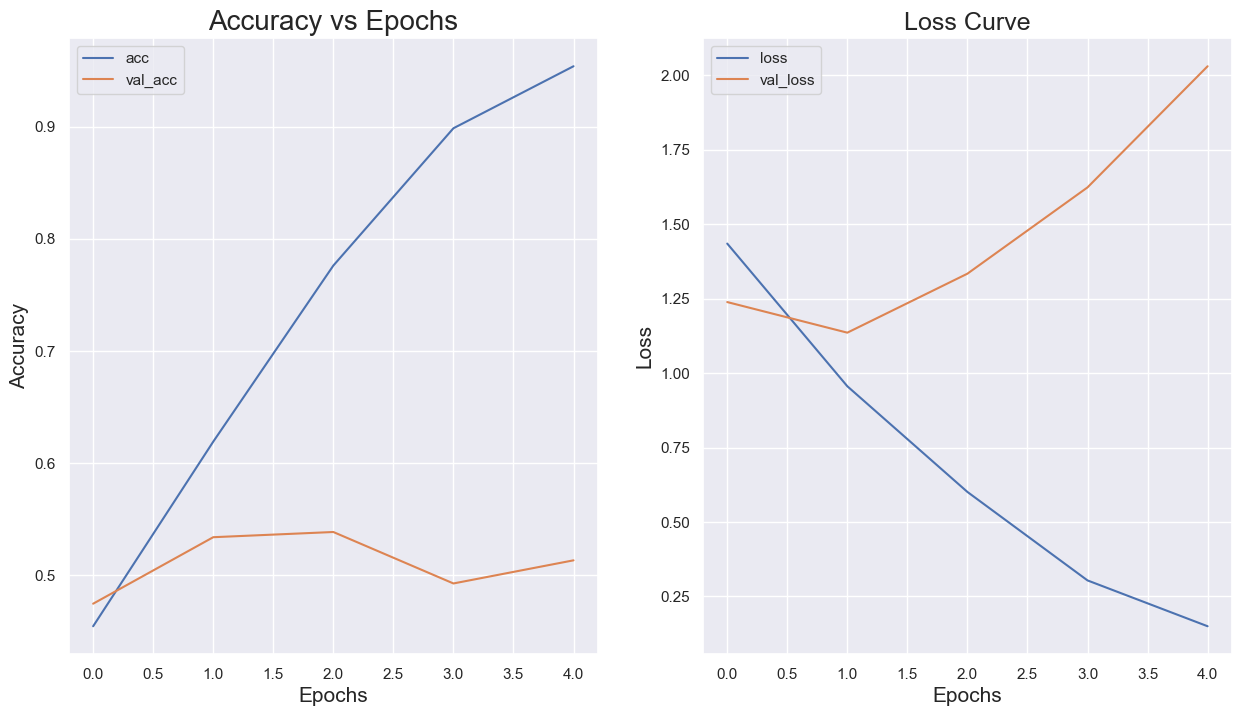

In [29]:
def model_performance_graphs():
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()
    
model_performance_graphs()

In [30]:
model.save(modelpath)

C:\Users\belsa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
loaded_model: tf.keras.Model = tf.keras.models.load_model(modelpath)

In [32]:
def preprocess_images(img):
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array / 255.0
    return img_preprocessed

In [33]:

test_images = ImageDataGenerator(rescale=1 / 255.0).flow_from_directory(
    test_dir, target_size=(224, 224), shuffle=False, batch_size=100
)

X_test, y_test = test_images.next()
y_test = np.argmax(y_test, axis=1)

Found 100 images belonging to 5 classes.


4/4 [==============================] - 1s 129ms/step


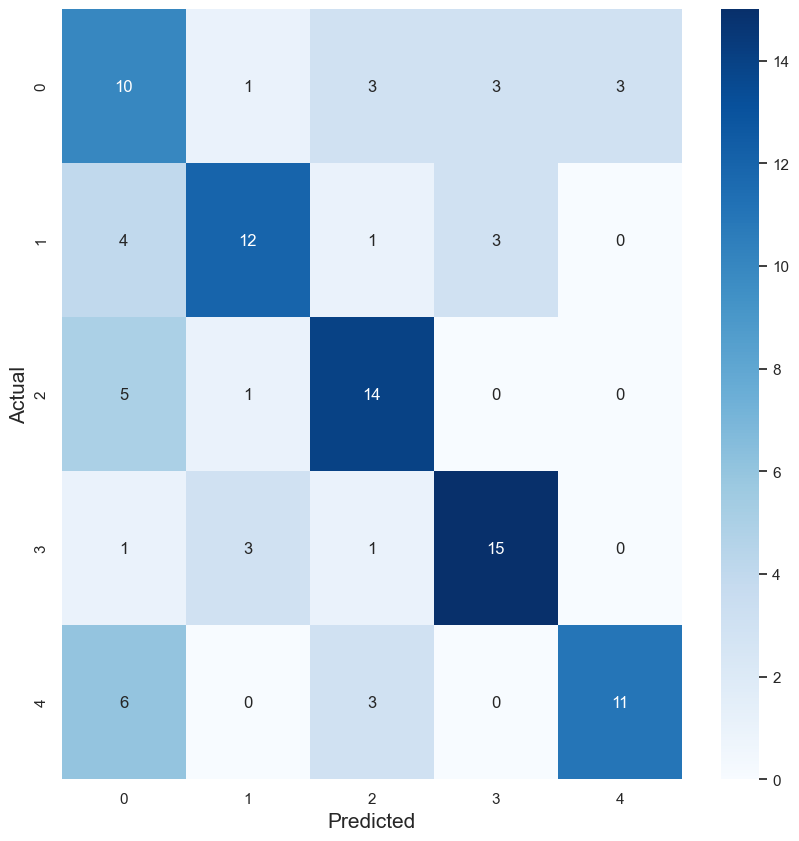

In [34]:
y_pred = np.argmax(loaded_model.predict(X_test), axis=1)

cmat = {i: {j: 0 for j in range(5)} for i in range(5)}

for t, p in zip(y_test, y_pred):
    cmat[t][p] += 1
    
cmat = pd.DataFrame(cmat).T

plt.figure(figsize=(10, 10))
sns.heatmap(cmat, annot=True, cmap="Blues")
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()